In [66]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore

In [67]:
sites = ['Dartmouth', 'Jefferson','Emory', 'UTSW']
sel_sub = pd.DataFrame([])
subs = []
for site in sites:
    #df = pd.read_excel(r'./' + site + '_neuropsych.xlsx',engine="openpyxl")
    df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
    for i in df.index:
        #gap = df.iloc[i]['Time between report and implant (days)']
        BDI = df.iloc[i]['BDI']
        BAI = df.iloc[i]['BAI']
        sub = df.iloc[i]['Subject Number']
        #if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
        if np.isnan(BDI)==False and np.isnan(BAI)==False:
            sel_sub = sel_sub.append({
                'subject':sub,
                'BDI':BDI,
                'BAI':BAI
                }, ignore_index = True)
sel_sub

,BAI,BDI,subject
0,3.0,6.0,32.0
1,4.0,3.0,33.0
2,27.0,14.0,98.0
3,11.0,39.0,100.0
4,9.0,8.0,116.0
...,...,...,...
161,6.0,0.0,457.0
162,18.0,13.0,474.0
163,5.0,3.0,478.0
164,4.0,3.0,531.0


In [68]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)
df_select

,BAI,BDI,subject
0,0.0,2.0,R1008J
1,2.0,1.0,R1010J
2,2.0,12.0,R1013E
3,7.0,15.0,R1015J
4,14.0,22.0,R1019J
...,...,...,...
136,15.0,17.0,R1566D
137,18.0,12.0,R1568E
138,1.0,23.0,R1582E
139,16.0,32.0,R1584J


In [70]:
trial_df = pd.DataFrame([])

experiments = ['FR1', 'catFR1']

for sub in df_select['subject']: ### 'sub' instead of 's' 
    try:
        for exp in experiments:
            localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

            for loc in localizations:
                montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

                for mont in montages: # iterate over montages            
                    data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                    sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                    for sess in sessions: # 'sess' instead of 'k' 
                        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                        evs = reader.load('task_events')
                        word_evs = evs[evs['type']=='REC_WORD']
    #                     rec_evs = word_evs[word_evs['recalled']==True]
                        s_dict = {} #create variables for each field and then append using Noa's technique

                        ### many times there are negative lists, referring to practice lists. You want to
                        # exclude those: word_evs['list'][word_evs['list']>0].unique() 
                        lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                        corr_recs = len(word_evs[word_evs['intrusion']==0]) # changed
                        ELIs = len(word_evs[word_evs['intrusion']==-1])
                        PLIs = len(word_evs[word_evs['intrusion']>0])
                        total_ints = ELIs + PLIs
                        total_trials = corr_recs + total_ints

                        trials = []
                        for list_num in word_evs['list'][word_evs['list']>0].unique():
                            list_events=word_evs[word_evs['list']==list_num]
                            if len(list_events)>0: 
                                for i in range(0,len(list_events)):
                                    trials.append(list_events.index[i])               
                        trial_df = trial_df.append({
                            'subject':sub,
                            'session': sess,
                            'montage': mont,
                            'localization': loc,
                            'experiment': exp,
                            'number of lists': lists,
                            'number of correct recalls': corr_recs,
                            'number of extra-list intrusions': ELIs,
                            'number of prior-list intrusions': PLIs,
                            'total number of intrusions': total_ints,
                            'total number of trials left': total_trials,
                            'trials for analysis': trials
                            },ignore_index=True) 
    except:
        print('Failed for subject:', sub)

In [135]:
catFR_df_filter = pd.DataFrame([])
FR_df_filter = pd.DataFrame([])
df_filter = pd.DataFrame([])

for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        allrec = trial_df.iloc[i]['total number of trials left']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
#         PLI_scaled = float(pli/correc)
#         ELI_scaled = float(eli/correc)
#         correc_scaled = float(correc/lists)
        PLI_scaled = float(pli/allrec)
        ELI_scaled = float(eli/allrec)
        correc_scaled = float(correc/allrec)
        if allrec > 0:
            df_filter = df_filter.append({
                'subject':sub,
                'experiment':exp,
                'correct recalls':correc,
                'ELIs':eli,
                'PLIs':pli,
                'total ints': eli+pli,
                'lists':lists,
                'correct recalls scaled':correc_scaled,
                'all recalls':allrec,
                'ELI scaled':ELI_scaled,
                'PLI scaled':PLI_scaled,
                'total scaled':ELI_scaled+PLI_scaled,
                'BAI':int(row['BAI'].values),
                'BDI':int(row['BDI'].values)
            }, ignore_index = True)
        else:
            print('removed row =', i, sub, exp)
    except:
        print('removed row =', i, sub, exp)


FR_df_filter = df_filter.query("experiment=='FR1'")
catFR_df_filter = df_filter.query("experiment=='catFR1'")
# for k in df_filter.index:
#     if df_filter.iloc[k]['experiment'] == 'FR1':
#         FR_df_filter = df_filter
#         df_filter = pd.DataFrame([])
#     elif exp == 'catFR1':
#         catFR_df_filter = df_filter
#         df_filter = pd.DataFrame([])
FR_df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


removed row = 3 R1015J FR1
removed row = 63 R1100D FR1
removed row = 64 R1100D FR1


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,all recalls,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,2.0,1.0,0.028571,2.0,0.171429,12.0,70.0,56.0,0.800000,FR1,23.0,R1010J,14.0,0.200000
1,2.0,1.0,0.059701,4.0,0.089552,6.0,67.0,57.0,0.850746,FR1,23.0,R1010J,10.0,0.149254
4,0.0,4.0,0.015625,2.0,0.054688,7.0,128.0,119.0,0.929688,FR1,25.0,R1020J,9.0,0.070312
5,3.0,1.0,0.204918,25.0,0.114754,14.0,122.0,83.0,0.680328,FR1,25.0,R1022J,39.0,0.319672
6,4.0,2.0,0.013158,1.0,0.013158,1.0,76.0,74.0,0.973684,FR1,21.0,R1023J,2.0,0.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,11.0,8.0,0.072464,5.0,0.014493,1.0,69.0,63.0,0.913043,FR1,12.0,R1542J,6.0,0.086957
356,11.0,8.0,0.013699,1.0,0.027397,2.0,73.0,70.0,0.958904,FR1,12.0,R1542J,3.0,0.041096
357,11.0,8.0,0.021053,2.0,0.010526,1.0,95.0,92.0,0.968421,FR1,12.0,R1542J,3.0,0.031579
358,11.0,8.0,0.031579,3.0,0.021053,2.0,95.0,90.0,0.947368,FR1,12.0,R1542J,5.0,0.052632


In [136]:
#average across sessions from the same subject
FR_avg_df = pd.DataFrame([])
FR_sub_df = FR_df_filter['subject'].unique()
for sub in FR_sub_df:
    trials = FR_df_filter[FR_df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    exp = trials.iloc[0]['experiment']
    FR_avg_df = FR_avg_df.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)

catFR_avg_df = pd.DataFrame([])
catFR_sub_df = catFR_df_filter['subject'].unique()
for sub in catFR_sub_df:
    trials = catFR_df_filter[catFR_df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    exp = trials.iloc[0]['experiment']
    catFR_avg_df = catFR_avg_df.append({
        'subject':sub,
        'experiment':exp,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)
catFR_avg_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject
0,2.0,12.0,0.000000,0.047619,0.952381,0.047619,catFR1,R1013E
1,7.0,15.0,0.050000,0.150000,0.800000,0.200000,catFR1,R1015J
2,3.0,6.0,0.039286,0.032143,0.928571,0.071429,catFR1,R1032D
3,2.0,7.0,0.000000,0.000000,1.000000,0.000000,catFR1,R1044J
4,7.0,8.0,0.001429,0.017858,0.980714,0.019286,catFR1,R1065J
...,...,...,...,...,...,...,...,...
67,5.0,6.0,0.050000,0.150000,0.800000,0.200000,catFR1,R1526J
68,18.0,16.0,0.022069,0.104354,0.873578,0.126422,catFR1,R1530J
69,12.0,21.0,0.120690,0.353448,0.525862,0.474138,catFR1,R1533J
70,24.0,17.0,0.048700,0.177993,0.773307,0.226693,catFR1,R1536J


In [137]:
FR_stats = FR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
catFR_stats = catFR_avg_df[['average ELIs', 'average PLIs', 'average correct recalls', 'average ints']]
#FR_stats.apply(zscore)
# for i in FR_avg_df.index:
FR_df_zscore = (FR_stats - FR_stats.mean())/FR_stats.std()
catFR_df_zscore = (catFR_stats - catFR_stats.mean())/catFR_stats.std()

FR_avg_df['zELI'] = FR_df_zscore['average ELIs']
FR_avg_df['zPLI'] = FR_df_zscore['average PLIs']
FR_avg_df['zints'] = FR_df_zscore['average ints']
FR_avg_df['zcorrec'] = FR_df_zscore['average correct recalls']

catFR_avg_df['zELI'] = catFR_df_zscore['average ELIs']
catFR_avg_df['zPLI'] = catFR_df_zscore['average PLIs']
catFR_avg_df['zints'] = catFR_df_zscore['average ints']
catFR_avg_df['zcorrec'] = catFR_df_zscore['average correct recalls']
catFR_avg_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,experiment,subject,zELI,zPLI,zints,zcorrec
0,2.0,12.0,0.000000,0.047619,0.952381,0.047619,catFR1,R1013E,-0.893522,-0.621503,-0.989456,0.989456
1,7.0,15.0,0.050000,0.150000,0.800000,0.200000,catFR1,R1015J,-0.407618,0.663023,0.076236,-0.076236
2,3.0,6.0,0.039286,0.032143,0.928571,0.071429,catFR1,R1032D,-0.511740,-0.815675,-0.822942,0.822942
3,2.0,7.0,0.000000,0.000000,1.000000,0.000000,catFR1,R1044J,-0.893522,-1.218957,-1.322485,1.322485
4,7.0,8.0,0.001429,0.017858,0.980714,0.019286,catFR1,R1065J,-0.879639,-0.994904,-1.187604,1.187604
...,...,...,...,...,...,...,...,...,...,...,...,...
67,5.0,6.0,0.050000,0.150000,0.800000,0.200000,catFR1,R1526J,-0.407618,0.663023,0.076236,-0.076236
68,18.0,16.0,0.022069,0.104354,0.873578,0.126422,catFR1,R1530J,-0.679057,0.090321,-0.438337,0.438337
69,12.0,21.0,0.120690,0.353448,0.525862,0.474138,catFR1,R1533J,0.279349,3.215594,1.993449,-1.993449
70,24.0,17.0,0.048700,0.177993,0.773307,0.226693,catFR1,R1536J,-0.420253,1.014244,0.262919,-0.262919


r =  0.18829059461151532 p =  0.10333836625776308
y = 0.02134565326067585 *x +  -0.21457998804153092


Text(0.5, 1.0, 'BAI vs zPLI')

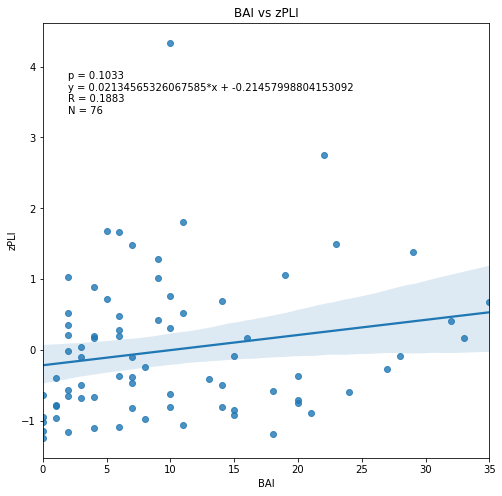

In [154]:
xi = 'BAI'
yi = 'zPLI' #'Average correct recalls'/'average ints'
exp = 'FR1'
if exp == 'FR1':
    sel_df = FR_avg_df
elif exp == 'catFR1':
    sel_df = catFR_avg_df

x = sel_df[xi]
y = sel_df[yi]
n = len(sel_df)

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
grad, inter, r, p, std_err = stats.linregress(x, y)

plt.figure(figsize=(8, 8))
# plt.scatter(x, y)
# plt.plot(x, poly1d_fn(x), '--k')
# max_x = round(x.max(axis = 0) + 5, 5)
# max_y = round(y.max(axis = 0) + 5, 5)
# plt.xticks(np.arange(0, max_x, 5))
# plt.yticks(np.arange(0, max_y, 10))
# plt.xlabel(xi)
# plt.ylabel(yi)
print('r = ',r, 'p = ', p)
print('y =', grad, '*x + ', inter)
plt.text(x.min()+2, y.max()-1, f"p = " + str(round(p, 4)) + '\n' + "y = " + str(grad) + "*x + " + str(inter) + '\n' + 'R = ' + str(round(r, 4)) + '\n' + 'N = ' + str(n))
g = sb.regplot(data = df_filter, x=x, y=y)
plt.title(xi + ' vs ' + yi)
#plt.savefig(xi +' vs '+ yi + '.pdf')
# ax.set_xlim(0, 25)
# ax.set_xticks(range(0,25), 5)
#add error bars, combine FR/pyFR, catFR separate, check out Courier
#remove 5s and 4 intrusion criteria